In [1]:
import torch
import torch.nn.functional as F
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# -------------------------------------------
# Dice coefficient computation for multilabel segmentation
def dice_coefficient(outputs, targets, threshold=0.5, smooth=1e-8):
    # Apply sigmoid to obtain probabilities and threshold to get binary predictions.
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    # Compute dice per channel: shape (B, C)
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

# -------------------------------------------
# Pixel accuracy computation
def pixel_accuracy(outputs, targets, threshold=0.5):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).float()
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return correct / total


In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import nibabel as nib

class CAMUSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 1) find all image files ending in .nii.gz
        image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.nii.gz')])

        # 2) build a list of (img_file, mask_file) pairs
        self.samples = []
        for img_file in image_files:
            # strip off '.nii.gz' and append '_gt.nii.gz' for the mask
            base = img_file[:-7]
            mask_file = base + '_gt.nii.gz'
            mask_path = os.path.join(mask_dir, mask_file)
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found for image {img_file}: expected {mask_file}")
            self.samples.append((img_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, mask_file = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        # load
        image = nib.load(img_path).get_fdata()
        mask  = nib.load(mask_path).get_fdata()

        # ensure channel dims
        image = np.expand_dims(image, axis=-1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        mask = mask.astype(np.int64)

        # spatial check
        if image.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Spatial mismatch: {img_file} {image.shape[:2]} vs {mask_file} {mask.shape[:2]}")

        # apply transforms
        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        # bring mask back to numpy for one‑hot
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        if mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.squeeze(-1)

        # one‑hot encode into 4 channels (background + 3 classes)
        H, W = mask.shape
        one_hot = np.zeros((4, H, W), dtype=np.float32)
        for c in range(4):
            one_hot[c] = (mask == c).astype(np.float32)

        mask = torch.tensor(one_hot, dtype=torch.float32)
        return image, mask


In [5]:
# -------------------------------------------
# Define Transformations with Data Augmentation
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
]
)

In [6]:

# -------------------------------------------
# Load Dataset and split into Train and Validation sets
img_dir = "/home/sailesh/Desktop/Rohit/dataset/nii_img"
mask_dir = "/home/sailesh/Desktop/Rohit/dataset/nii_gt"
full_dataset = CAMUSDataset(img_dir=img_dir, mask_dir=mask_dir, transform=transform)
dataset_size = len(full_dataset)
print(dataset_size)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


2000


In [6]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="densenet121",      # ← change this
    encoder_weights="imagenet",      # keep pretrained weights if you like
    in_channels=1,                   # your input is still single‑channel
    classes=4,                       # number of output masks
    activation=None                  # logits output for BCEWithLogitsLoss
)
model = model.to(device)




In [7]:
model

Unet(
  (encoder): DenseNetEncoder(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

In [8]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, 1, height, width]
summary(model, input_size=[4, 1, 256 , 256])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [4, 4, 256, 256]          --
├─DenseNetEncoder: 1-1                        [4, 1, 256, 256]          --
│    └─Sequential: 2-1                        --                        --
│    │    └─Conv2d: 3-1                       [4, 64, 128, 128]         3,136
│    │    └─BatchNorm2d: 3-2                  [4, 64, 128, 128]         128
│    │    └─ReLU: 3-3                         [4, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                    [4, 64, 64, 64]           --
│    │    └─_DenseBlock: 3-5                  [4, 256, 64, 64]          335,040
│    │    └─_Transition: 3-6                  --                        33,280
│    │    └─_DenseBlock: 3-7                  [4, 512, 32, 32]          919,680
│    │    └─_Transition: 3-8                  --                        132,096
│    │    └─_DenseBlock: 3-9                  [4, 1024, 16, 16]         

In [11]:
import torch
import torch.optim as optim
import numpy as np
from tqdm import tqdm

# Make sure that your model is defined and moved to the correct device beforehand.
# Also ensure that the model's final layer outputs 4 channels (for the one-hot mask).
# Example: model = YourModel(...).to(device)

# -------------------------------------------
# Define Loss and Optimizer with L2 Regularization
criterion = torch.nn.BCEWithLogitsLoss()  # Suitable for multi-label segmentation with one-hot targets
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# -------------------------------------------
# Training Loop with Training + Validation Metrics and tqdm
num_epochs = 50  # Increased epochs to 50

# Lists to store epoch-level metrics
train_loss_list = []
train_dice_mean_list = []
train_dice_std_list = []
train_acc_mean_list = []
train_acc_std_list = []

val_loss_list = []
val_dice_mean_list = []
val_dice_std_list = []
val_acc_mean_list = []
val_acc_std_list = []

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    dice_train_epoch = []
    acc_train_epoch = []
    train_steps = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate dice and accuracy for this batch (make sure dice_coefficient and pixel_accuracy
        # are defined to work with one-hot masks and outputs with 4 channels)
        dice = dice_coefficient(outputs, masks)
        acc = pixel_accuracy(outputs, masks)
        dice_train_epoch.append(dice.item())
        acc_train_epoch.append(acc.item())
        
        train_steps += 1

    epoch_train_loss = running_loss / train_steps
    epoch_train_dice_mean = np.mean(dice_train_epoch)
    epoch_train_dice_std = np.std(dice_train_epoch)
    epoch_train_acc_mean = np.mean(acc_train_epoch)
    epoch_train_acc_std = np.std(acc_train_epoch)
    
    train_loss_list.append(epoch_train_loss)
    train_dice_mean_list.append(epoch_train_dice_mean)
    train_dice_std_list.append(epoch_train_dice_std)
    train_acc_mean_list.append(epoch_train_acc_mean)
    train_acc_std_list.append(epoch_train_acc_std)
    
    # --- Validation Phase ---
    model.eval()
    running_loss = 0.0
    dice_val_epoch = []
    acc_val_epoch = []
    val_steps = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            dice = dice_coefficient(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            dice_val_epoch.append(dice.item())
            acc_val_epoch.append(acc.item())
            
            val_steps += 1

    epoch_val_loss = running_loss / val_steps
    epoch_val_dice_mean = np.mean(dice_val_epoch)
    epoch_val_dice_std = np.std(dice_val_epoch)
    epoch_val_acc_mean = np.mean(acc_val_epoch)
    epoch_val_acc_std = np.std(acc_val_epoch)
    
    val_loss_list.append(epoch_val_loss)
    val_dice_mean_list.append(epoch_val_dice_mean)
    val_dice_std_list.append(epoch_val_dice_std)
    val_acc_mean_list.append(epoch_val_acc_mean)
    val_acc_std_list.append(epoch_val_acc_std)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train  - Loss: {epoch_train_loss:.4f}, Dice: {epoch_train_dice_mean:.4f} ± {epoch_train_dice_std:.4f}, Accuracy: {epoch_train_acc_mean:.4f} ± {epoch_train_acc_std:.4f}")
    print(f"  Val    - Loss: {epoch_val_loss:.4f}, Dice: {epoch_val_dice_mean:.4f} ± {epoch_val_dice_std:.4f}, Accuracy: {epoch_val_acc_mean:.4f} ± {epoch_val_acc_std:.4f}")

# -------------------------------------------
# Save the Final Model to a .pth file
model_save_path = "/home/sailesh/Desktop/Rohit/Combined/denseNet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.29it/s]


Epoch 1/50:
  Train  - Loss: 0.2736, Dice: 0.7931 ± 0.1187, Accuracy: 0.9452 ± 0.0545
  Val    - Loss: 0.1388, Dice: 0.8710 ± 0.0240, Accuracy: 0.9718 ± 0.0047


Epoch 2/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 14.08it/s]


Epoch 2/50:
  Train  - Loss: 0.1024, Dice: 0.8858 ± 0.0249, Accuracy: 0.9752 ± 0.0054
  Val    - Loss: 0.0806, Dice: 0.8971 ± 0.0226, Accuracy: 0.9768 ± 0.0041


Epoch 3/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


Epoch 3/50:
  Train  - Loss: 0.0690, Dice: 0.9020 ± 0.0204, Accuracy: 0.9787 ± 0.0045
  Val    - Loss: 0.0623, Dice: 0.9029 ± 0.0210, Accuracy: 0.9791 ± 0.0036


Epoch 4/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


Epoch 4/50:
  Train  - Loss: 0.0568, Dice: 0.9088 ± 0.0171, Accuracy: 0.9802 ± 0.0038
  Val    - Loss: 0.0577, Dice: 0.9038 ± 0.0185, Accuracy: 0.9786 ± 0.0043


Epoch 5/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.50it/s]


Epoch 5/50:
  Train  - Loss: 0.0505, Dice: 0.9132 ± 0.0171, Accuracy: 0.9812 ± 0.0036
  Val    - Loss: 0.0499, Dice: 0.9114 ± 0.0206, Accuracy: 0.9808 ± 0.0043


Epoch 6/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


Epoch 6/50:
  Train  - Loss: 0.0463, Dice: 0.9169 ± 0.0174, Accuracy: 0.9820 ± 0.0037
  Val    - Loss: 0.0471, Dice: 0.9164 ± 0.0189, Accuracy: 0.9814 ± 0.0037


Epoch 7/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


Epoch 7/50:
  Train  - Loss: 0.0435, Dice: 0.9205 ± 0.0158, Accuracy: 0.9826 ± 0.0031
  Val    - Loss: 0.0464, Dice: 0.9182 ± 0.0166, Accuracy: 0.9813 ± 0.0039


Epoch 8/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


Epoch 8/50:
  Train  - Loss: 0.0406, Dice: 0.9246 ± 0.0132, Accuracy: 0.9835 ± 0.0028
  Val    - Loss: 0.0465, Dice: 0.9152 ± 0.0161, Accuracy: 0.9806 ± 0.0035


Epoch 9/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.53it/s]


Epoch 9/50:
  Train  - Loss: 0.0389, Dice: 0.9266 ± 0.0132, Accuracy: 0.9840 ± 0.0030
  Val    - Loss: 0.0452, Dice: 0.9167 ± 0.0164, Accuracy: 0.9813 ± 0.0036


Epoch 10/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.85it/s]


Epoch 10/50:
  Train  - Loss: 0.0380, Dice: 0.9279 ± 0.0131, Accuracy: 0.9843 ± 0.0028
  Val    - Loss: 0.0438, Dice: 0.9206 ± 0.0178, Accuracy: 0.9820 ± 0.0035


Epoch 11/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.61it/s]


Epoch 11/50:
  Train  - Loss: 0.0392, Dice: 0.9247 ± 0.0172, Accuracy: 0.9837 ± 0.0036
  Val    - Loss: 0.0491, Dice: 0.9104 ± 0.0244, Accuracy: 0.9800 ± 0.0051


Epoch 12/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


Epoch 12/50:
  Train  - Loss: 0.0375, Dice: 0.9279 ± 0.0141, Accuracy: 0.9843 ± 0.0030
  Val    - Loss: 0.0436, Dice: 0.9214 ± 0.0142, Accuracy: 0.9820 ± 0.0036


Epoch 13/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Epoch 13/50:
  Train  - Loss: 0.0346, Dice: 0.9327 ± 0.0117, Accuracy: 0.9854 ± 0.0024
  Val    - Loss: 0.0415, Dice: 0.9227 ± 0.0139, Accuracy: 0.9826 ± 0.0034


Epoch 14/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


Epoch 14/50:
  Train  - Loss: 0.0331, Dice: 0.9354 ± 0.0106, Accuracy: 0.9859 ± 0.0025
  Val    - Loss: 0.0408, Dice: 0.9255 ± 0.0135, Accuracy: 0.9829 ± 0.0031


Epoch 15/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


Epoch 15/50:
  Train  - Loss: 0.0324, Dice: 0.9364 ± 0.0112, Accuracy: 0.9862 ± 0.0022
  Val    - Loss: 0.0412, Dice: 0.9245 ± 0.0119, Accuracy: 0.9828 ± 0.0032


Epoch 16/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Epoch 16/50:
  Train  - Loss: 0.0312, Dice: 0.9382 ± 0.0103, Accuracy: 0.9866 ± 0.0022
  Val    - Loss: 0.0436, Dice: 0.9215 ± 0.0159, Accuracy: 0.9823 ± 0.0036


Epoch 17/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Epoch 17/50:
  Train  - Loss: 0.0310, Dice: 0.9389 ± 0.0102, Accuracy: 0.9867 ± 0.0021
  Val    - Loss: 0.0428, Dice: 0.9216 ± 0.0160, Accuracy: 0.9823 ± 0.0034


Epoch 18/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


Epoch 18/50:
  Train  - Loss: 0.0299, Dice: 0.9406 ± 0.0097, Accuracy: 0.9871 ± 0.0020
  Val    - Loss: 0.0439, Dice: 0.9216 ± 0.0161, Accuracy: 0.9822 ± 0.0033


Epoch 19/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.65it/s]


Epoch 19/50:
  Train  - Loss: 0.0299, Dice: 0.9408 ± 0.0097, Accuracy: 0.9871 ± 0.0021
  Val    - Loss: 0.0422, Dice: 0.9223 ± 0.0167, Accuracy: 0.9826 ± 0.0033


Epoch 20/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


Epoch 20/50:
  Train  - Loss: 0.0289, Dice: 0.9428 ± 0.0087, Accuracy: 0.9875 ± 0.0019
  Val    - Loss: 0.0420, Dice: 0.9243 ± 0.0135, Accuracy: 0.9828 ± 0.0032


Epoch 21/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


Epoch 21/50:
  Train  - Loss: 0.0286, Dice: 0.9432 ± 0.0094, Accuracy: 0.9877 ± 0.0020
  Val    - Loss: 0.0428, Dice: 0.9239 ± 0.0154, Accuracy: 0.9827 ± 0.0032


Epoch 22/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.43it/s]


Epoch 22/50:
  Train  - Loss: 0.0281, Dice: 0.9442 ± 0.0094, Accuracy: 0.9879 ± 0.0019
  Val    - Loss: 0.0446, Dice: 0.9215 ± 0.0186, Accuracy: 0.9825 ± 0.0036


Epoch 23/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 14.10it/s]


Epoch 23/50:
  Train  - Loss: 0.0270, Dice: 0.9461 ± 0.0088, Accuracy: 0.9883 ± 0.0018
  Val    - Loss: 0.0436, Dice: 0.9247 ± 0.0132, Accuracy: 0.9826 ± 0.0032


Epoch 24/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.49it/s]


Epoch 24/50:
  Train  - Loss: 0.0270, Dice: 0.9461 ± 0.0100, Accuracy: 0.9883 ± 0.0020
  Val    - Loss: 0.0517, Dice: 0.9092 ± 0.0140, Accuracy: 0.9797 ± 0.0035


Epoch 25/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.59it/s]


Epoch 25/50:
  Train  - Loss: 0.0306, Dice: 0.9391 ± 0.0126, Accuracy: 0.9869 ± 0.0025
  Val    - Loss: 0.0427, Dice: 0.9215 ± 0.0166, Accuracy: 0.9826 ± 0.0032


Epoch 26/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.72it/s]


Epoch 26/50:
  Train  - Loss: 0.0265, Dice: 0.9473 ± 0.0086, Accuracy: 0.9885 ± 0.0019
  Val    - Loss: 0.0433, Dice: 0.9249 ± 0.0143, Accuracy: 0.9827 ± 0.0032


Epoch 27/50 - Validation: 100%|██████████| 100/100 [00:06<00:00, 14.30it/s]


Epoch 27/50:
  Train  - Loss: 0.0258, Dice: 0.9488 ± 0.0085, Accuracy: 0.9889 ± 0.0018
  Val    - Loss: 0.0427, Dice: 0.9253 ± 0.0127, Accuracy: 0.9830 ± 0.0029


Epoch 28/50 - Validation: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


Epoch 28/50:
  Train  - Loss: 0.0255, Dice: 0.9492 ± 0.0080, Accuracy: 0.9890 ± 0.0017
  Val    - Loss: 0.0427, Dice: 0.9262 ± 0.0145, Accuracy: 0.9832 ± 0.0032


Epoch 29/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


Epoch 29/50:
  Train  - Loss: 0.0244, Dice: 0.9514 ± 0.0073, Accuracy: 0.9894 ± 0.0016
  Val    - Loss: 0.0447, Dice: 0.9243 ± 0.0170, Accuracy: 0.9829 ± 0.0033


Epoch 30/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


Epoch 30/50:
  Train  - Loss: 0.0248, Dice: 0.9503 ± 0.0092, Accuracy: 0.9893 ± 0.0016
  Val    - Loss: 0.0457, Dice: 0.9238 ± 0.0179, Accuracy: 0.9826 ± 0.0035


Epoch 31/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]


Epoch 31/50:
  Train  - Loss: 0.0258, Dice: 0.9491 ± 0.0093, Accuracy: 0.9889 ± 0.0020
  Val    - Loss: 0.0425, Dice: 0.9271 ± 0.0146, Accuracy: 0.9835 ± 0.0031


Epoch 32/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


Epoch 32/50:
  Train  - Loss: 0.0232, Dice: 0.9532 ± 0.0076, Accuracy: 0.9899 ± 0.0015
  Val    - Loss: 0.0452, Dice: 0.9260 ± 0.0164, Accuracy: 0.9832 ± 0.0034


Epoch 33/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


Epoch 33/50:
  Train  - Loss: 0.0232, Dice: 0.9536 ± 0.0072, Accuracy: 0.9900 ± 0.0016
  Val    - Loss: 0.0430, Dice: 0.9273 ± 0.0127, Accuracy: 0.9835 ± 0.0028


Epoch 34/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]


Epoch 34/50:
  Train  - Loss: 0.0231, Dice: 0.9537 ± 0.0071, Accuracy: 0.9900 ± 0.0015
  Val    - Loss: 0.0457, Dice: 0.9249 ± 0.0125, Accuracy: 0.9829 ± 0.0033


Epoch 35/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.44it/s]


Epoch 35/50:
  Train  - Loss: 0.0227, Dice: 0.9544 ± 0.0067, Accuracy: 0.9902 ± 0.0013
  Val    - Loss: 0.0444, Dice: 0.9275 ± 0.0144, Accuracy: 0.9835 ± 0.0032


Epoch 36/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.93it/s]


Epoch 36/50:
  Train  - Loss: 0.0226, Dice: 0.9549 ± 0.0075, Accuracy: 0.9902 ± 0.0015
  Val    - Loss: 0.0440, Dice: 0.9270 ± 0.0133, Accuracy: 0.9833 ± 0.0030


Epoch 37/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


Epoch 37/50:
  Train  - Loss: 0.0233, Dice: 0.9535 ± 0.0070, Accuracy: 0.9899 ± 0.0016
  Val    - Loss: 0.0442, Dice: 0.9266 ± 0.0137, Accuracy: 0.9832 ± 0.0033


Epoch 38/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


Epoch 38/50:
  Train  - Loss: 0.0227, Dice: 0.9547 ± 0.0069, Accuracy: 0.9902 ± 0.0015
  Val    - Loss: 0.0442, Dice: 0.9277 ± 0.0151, Accuracy: 0.9836 ± 0.0034


Epoch 39/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


Epoch 39/50:
  Train  - Loss: 0.0221, Dice: 0.9558 ± 0.0067, Accuracy: 0.9904 ± 0.0014
  Val    - Loss: 0.0453, Dice: 0.9268 ± 0.0141, Accuracy: 0.9833 ± 0.0035


Epoch 40/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


Epoch 40/50:
  Train  - Loss: 0.0220, Dice: 0.9560 ± 0.0074, Accuracy: 0.9905 ± 0.0015
  Val    - Loss: 0.0465, Dice: 0.9247 ± 0.0155, Accuracy: 0.9830 ± 0.0034


Epoch 41/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


Epoch 41/50:
  Train  - Loss: 0.0220, Dice: 0.9558 ± 0.0087, Accuracy: 0.9905 ± 0.0016
  Val    - Loss: 0.0442, Dice: 0.9285 ± 0.0150, Accuracy: 0.9837 ± 0.0030


Epoch 42/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


Epoch 42/50:
  Train  - Loss: 0.0213, Dice: 0.9574 ± 0.0061, Accuracy: 0.9907 ± 0.0014
  Val    - Loss: 0.0459, Dice: 0.9281 ± 0.0125, Accuracy: 0.9835 ± 0.0031


Epoch 43/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.57it/s]


Epoch 43/50:
  Train  - Loss: 0.0211, Dice: 0.9577 ± 0.0070, Accuracy: 0.9909 ± 0.0015
  Val    - Loss: 0.0461, Dice: 0.9267 ± 0.0145, Accuracy: 0.9834 ± 0.0031


Epoch 44/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


Epoch 44/50:
  Train  - Loss: 0.0211, Dice: 0.9577 ± 0.0066, Accuracy: 0.9908 ± 0.0014
  Val    - Loss: 0.0464, Dice: 0.9260 ± 0.0152, Accuracy: 0.9833 ± 0.0034


Epoch 45/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


Epoch 45/50:
  Train  - Loss: 0.0211, Dice: 0.9580 ± 0.0071, Accuracy: 0.9909 ± 0.0014
  Val    - Loss: 0.0458, Dice: 0.9289 ± 0.0126, Accuracy: 0.9836 ± 0.0030


Epoch 46/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.29it/s]


Epoch 46/50:
  Train  - Loss: 0.0208, Dice: 0.9584 ± 0.0073, Accuracy: 0.9910 ± 0.0014
  Val    - Loss: 0.0454, Dice: 0.9268 ± 0.0118, Accuracy: 0.9833 ± 0.0030


Epoch 47/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 16.94it/s]


Epoch 47/50:
  Train  - Loss: 0.0204, Dice: 0.9594 ± 0.0065, Accuracy: 0.9912 ± 0.0013
  Val    - Loss: 0.0477, Dice: 0.9257 ± 0.0160, Accuracy: 0.9833 ± 0.0032


Epoch 48/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


Epoch 48/50:
  Train  - Loss: 0.0203, Dice: 0.9593 ± 0.0067, Accuracy: 0.9912 ± 0.0014
  Val    - Loss: 0.0472, Dice: 0.9263 ± 0.0154, Accuracy: 0.9833 ± 0.0032


Epoch 49/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Epoch 49/50:
  Train  - Loss: 0.0202, Dice: 0.9595 ± 0.0064, Accuracy: 0.9912 ± 0.0013
  Val    - Loss: 0.0456, Dice: 0.9280 ± 0.0142, Accuracy: 0.9837 ± 0.0031


Epoch 50/50 - Validation: 100%|██████████| 100/100 [00:05<00:00, 17.73it/s]


Epoch 50/50:
  Train  - Loss: 0.0195, Dice: 0.9608 ± 0.0060, Accuracy: 0.9915 ± 0.0012
  Val    - Loss: 0.0467, Dice: 0.9292 ± 0.0126, Accuracy: 0.9838 ± 0.0032
Model saved to /home/sailesh/Desktop/Rohit/Combined/denseNet.pth


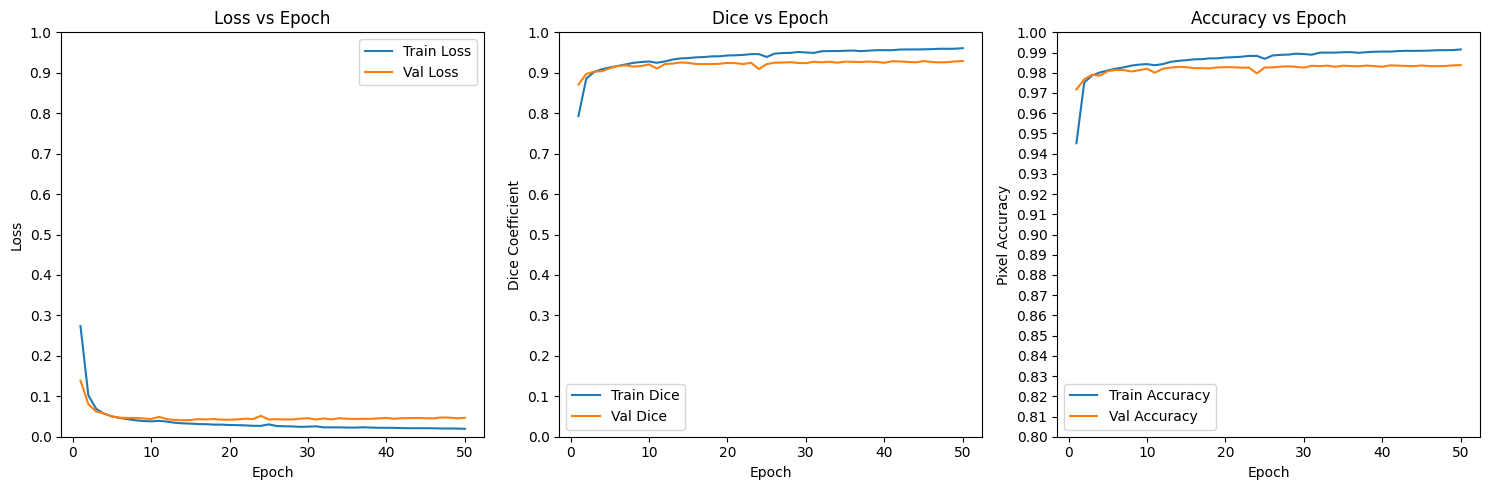

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined:
# num_epochs, train_loss_list, val_loss_list,
# train_dice_mean_list, val_dice_mean_list,
# train_acc_mean_list, val_acc_mean_list

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(15, 5))

# Loss vs Epoch
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss", linestyle='-')
plt.plot(epochs_range, val_loss_list, label="Val Loss", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Dice vs Epoch
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice_mean_list, label="Train Dice", linestyle='-')
plt.plot(epochs_range, val_dice_mean_list, label="Val Dice", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Dice vs Epoch")
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))

# Accuracy vs Epoch (Y-axis adjusted from 0.8 to 1 with 0.01 scale)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_acc_mean_list, label="Train Accuracy", linestyle='-')
plt.plot(epochs_range, val_acc_mean_list, label="Val Accuracy", linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Pixel Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.ylim(0.8, 1)
plt.yticks(np.arange(0.8, 1.001, 0.01))

plt.tight_layout()
plt.show()


C:\Users\rohit\AppData\Local\Temp\ipykernel_15304\3879156482.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_locat

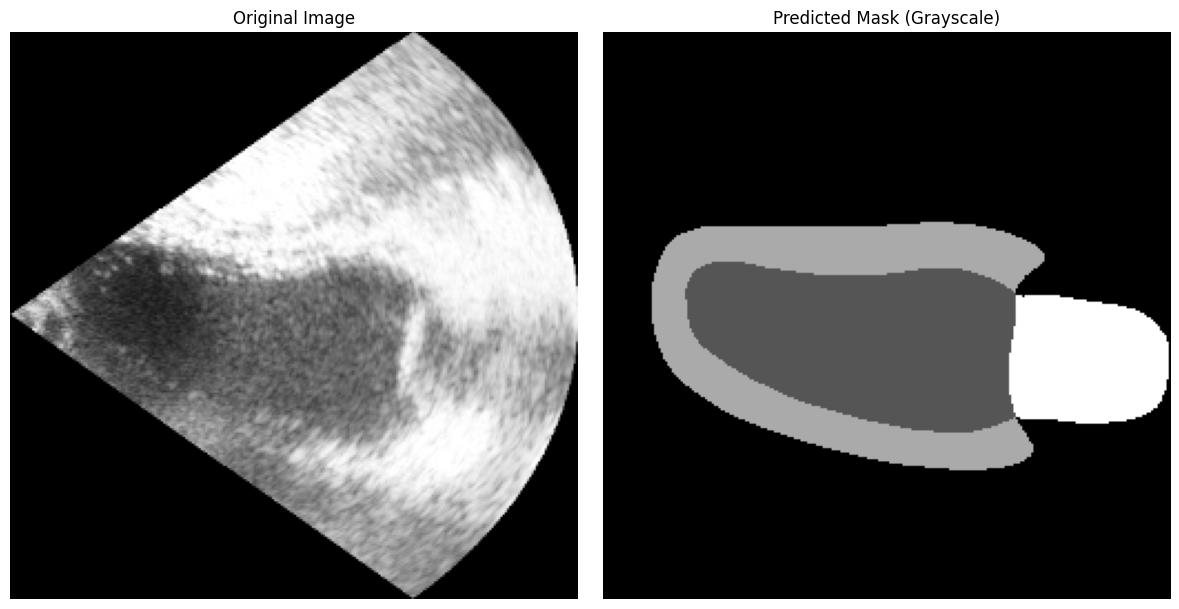

In [9]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import cv2  # For resizing and saving

# ----------------------------
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Load the trained model
model_save_path = r"E:\PROJECTS\Mini_Project\sem_6\Combined\denseNet.pth"  # Update with your model path
model = smp.Unet(
    encoder_name="densenet121",
    encoder_weights="imagenet",
    in_channels=1,
    classes=4,        # Background + three foreground classes
    activation=None   # No activation (we'll apply sigmoid + argmax ourselves)
)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

# ----------------------------
# Load the input .nii.gz file
input_file = r"E:\PROJECTS\Mini_Project\sem_6\nii_img\patient0001_2CH_ED.nii.gz"  # Update with your input file
nii_img = nib.load(input_file)
img_data = nii_img.get_fdata()

# Select a 2D slice if 3D
if img_data.ndim == 3:
    slice_index = img_data.shape[2] // 2
    img_slice = img_data[:, :, slice_index]
elif img_data.ndim == 2:
    img_slice = img_data
else:
    raise ValueError(f"Unexpected image dimensions: {img_data.shape}")

# Normalize to [0,1]
img_min, img_max = img_slice.min(), img_slice.max()
if img_max > img_min:
    img_slice = (img_slice - img_min) / (img_max - img_min)

# Resize to 256×256
img_resized = cv2.resize(img_slice.astype(np.float32), (256, 256))

# Prepare tensor: (B=1, C=1, H=256, W=256)
img_tensor = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).to(device)

# ----------------------------
# Run inference
with torch.no_grad():
    logits = model(img_tensor)               # (1, 4, 256, 256)
    probs  = torch.sigmoid(logits)           # (1, 4, 256, 256)
    pred_mask = torch.argmax(probs, dim=1)   # (1, 256, 256)
    pred_mask = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)

# ----------------------------
# Optional: save the raw mask as a single‐channel PNG
# Scale classes {0,1,2,3} → {0,85,170,255} for visibility
mask_to_save = (pred_mask * (255 // 3)).astype(np.uint8)
cv2.imwrite("pred_mask_gray.png", mask_to_save)

# ----------------------------
# Display side‐by‐side: original vs. predicted mask in grayscale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img_resized, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask
axes[1].imshow(pred_mask, cmap="gray", vmin=0, vmax=3)
axes[1].set_title("Predicted Mask (Grayscale)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("segmentation_side_by_side_gray.png", bbox_inches="tight", pad_inches=0)
plt.show()


In [16]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported

# -------------------------------
# Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient over all channels.
    Expects y_true and y_pred in shape (H, W, channels) or (batch, H, W, channels).
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) over all channels.
    Expects y_true and y_pred in shape (H, W, channels) or (batch, H, W, channels).
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=1):
    
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_multi(y_true, y_pred):
    """
    Compute the mean absolute distance (MAD) between the boundaries of masks,
    channel-by-channel, and return the average.
    """
    distances = []
    channels = y_true.shape[-1]
    for i in range(channels):
        channel_true = y_true[..., i]
        channel_pred = y_pred[..., i]
        # Convert masks to 0-255 and uint8 for contour extraction
        mask_true = (channel_true * 255).astype(np.uint8)
        mask_pred = (channel_pred * 255).astype(np.uint8)
        contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours_true) == 0 or len(contours_pred) == 0:
            distances.append(np.nan)
        else:
            # Combine all contour points for each mask
            points_true = np.vstack(contours_true)[:, 0, :]
            points_pred = np.vstack(contours_pred)[:, 0, :]
            dists = []
            for pt in points_true:
                dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
            distances.append(np.mean(dists))
    return np.nanmean(distances)

def compute_mae(y_true, y_pred):
    """
    Compute Mean Absolute Error between masks (pixel-wise).
    """
    return mean_absolute_error(y_true.flatten(), y_pred.flatten())

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient between ground truth and prediction.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function
# -------------------------------

def evaluate_model(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model on the given dataloader and compute various metrics.
    Assumes the model outputs logits and the masks are in the range [0,1].
    """
    dice_scores = []
    jaccard_scores = []
    hausdorff_scores = []
    mae_scores = []
    mad_scores = []
    accuracies = []
    precisions = []
    recalls = []
    correlations = []

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            # If the model returns a tuple, select the first element
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Apply sigmoid and threshold to get binary predictions
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move to CPU and convert to numpy
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # The outputs are of shape (batch, channels, H, W).
            # For our metric functions, we transpose to (batch, H, W, channels).
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                # Binarize the ground truth mask if necessary
                true_mask_binary = (true_mask > threshold).astype(np.float32)

                dice_scores.append(dice_coefficient(true_mask_binary, pred_mask))
                jaccard_scores.append(jaccard_index(true_mask_binary, pred_mask))
                hausdorff_scores.append(hausdorff_distance_single(true_mask_binary, pred_mask))
                mae_scores.append(compute_mae(true_mask_binary, pred_mask))
                mad_scores.append(mean_absolute_distance_multi(true_mask_binary, pred_mask))

                acc, prec, rec = compute_classification_metrics(true_mask_binary, pred_mask)
                accuracies.append(acc)
                precisions.append(prec)
                recalls.append(rec)

                correlations.append(compute_correlation(true_mask_binary, pred_mask))

    print("---- Evaluation Metrics ----")
    print("Average Dice Coefficient    : {:.4f} ± {:.4f}".format(np.nanmean(dice_scores), np.nanstd(dice_scores)))
    print("Average Jaccard Index       : {:.4f} ± {:.4f}".format(np.nanmean(jaccard_scores), np.nanstd(jaccard_scores)))
    print("Average Hausdorff Distance  : {:.4f} ± {:.4f}".format(np.nanmean(hausdorff_scores), np.nanstd(hausdorff_scores)))
    print("Average Mean Absolute Error : {:.4f} ± {:.4f}".format(np.mean(mae_scores), np.std(mae_scores)))
    print("Average Mean Absolute Dist  : {:.4f} ± {:.4f}".format(np.mean(mad_scores), np.std(mad_scores)))
    print("Average Accuracy            : {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))
    print("Average Precision           : {:.4f} ± {:.4f}".format(np.mean(precisions), np.std(precisions)))
    print("Average Recall              : {:.4f} ± {:.4f}".format(np.mean(recalls), np.std(recalls)))
    print("Average Correlation         : {:.4f} ± {:.4f}".format(np.mean(correlations), np.std(correlations)))

# -------------------------------
# Example usage:
# -------------------------------
# Assuming `model`, `val_loader`, and `device` are defined,
# and that the model weights have been loaded correctly.

# Load your saved model weights onto CPU
model.load_state_dict(torch.load(r'/home/sailesh/Desktop/Rohit/Combined/denseNet.pth'))
model.to(device)  # device here is 'cpu'
model.eval()

# Evaluate on the validation DataLoader
evaluate_model(model, val_loader, device)


---- Evaluation Metrics ----
Average Dice Coefficient    : 0.9672 ± 0.0127
Average Jaccard Index       : 0.9368 ± 0.0235
Average Hausdorff Distance  : 3.0045 ± 0.1135
Average Mean Absolute Error : 0.0164 ± 0.0064
Average Mean Absolute Dist  : 1.9431 ± 1.1059
Average Accuracy            : 0.9836 ± 0.0064
Average Precision           : 0.9673 ± 0.0127
Average Recall              : 0.9672 ± 0.0127
Average Correlation         : 0.9563 ± 0.0170


In [17]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff  # No longer used in soft version
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer

    # Compute the minimum distance from each point in coords_true to any point in coords_pred.
    min_distances_true_to_pred = [np.min(np.linalg.norm(coords_pred - a, axis=1))
                                  for a in coords_true]
    max_true_to_pred = np.max(min_distances_true_to_pred)

    # Compute the minimum distance from each point in coords_pred to any point in coords_true.
    min_distances_pred_to_true = [np.min(np.linalg.norm(coords_true - b, axis=1))
                                  for b in coords_pred]
    max_pred_to_true = np.max(min_distances_pred_to_true)

    # The Hausdorff distance is the maximum of these two distances.
    distance_in_pixels = max(max_true_to_pred, max_pred_to_true)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel (lobe) separately.
    Assumes:
      - The model outputs logits.
      - The ground truth masks are in the range [0, 1].
      - There are 4 channels: channel 0 is background and channels 1, 2, and 3 correspond to Lobe_1, Lobe_2, and Lobe_3.
    """
    num_segments = 4  # Background + 3 lobes

    # Create a list for each metric per channel
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            # If the model returns a tuple, select the first element
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                # Iterate over segmentation channels (skip background channel 0)
                for seg in range(1, num_segments):
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Binarize the ground truth channel using the same threshold
                    channel_true_bin = (channel_true > threshold).astype(np.float32)

                    dice_scores[seg].append(dice_coefficient(channel_true_bin, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true_bin, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true_bin, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true_bin.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true_bin, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true_bin, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true_bin, channel_pred))

    # Print averaged metrics (mean ± standard deviation) for each lobe (skipping background)
    for seg in range(1, num_segments):
        print(f"---- Metrics for Lobe_{seg} ----")
        print("Dice Coefficient    : {:.4f} ± {:.4f}".format(np.nanmean(dice_scores[seg]), np.nanstd(dice_scores[seg])))
        print("Jaccard Index       : {:.4f} ± {:.4f}".format(np.nanmean(jaccard_scores[seg]), np.nanstd(jaccard_scores[seg])))
        print("Hausdorff Distance  : {:.4f} ± {:.4f}".format(np.nanmean(hausdorff_scores[seg]), np.nanstd(hausdorff_scores[seg])))
        print("Mean Absolute Error : {:.4f} ± {:.4f}".format(np.mean(mae_scores[seg]), np.std(mae_scores[seg])))
        print("Mean Absolute Dist  : {:.4f} ± {:.4f}".format(np.mean(mad_scores[seg]), np.std(mad_scores[seg])))
        print("Accuracy            : {:.4f} ± {:.4f}".format(np.mean(accuracies[seg]), np.std(accuracies[seg])))
        print("Precision           : {:.4f} ± {:.4f}".format(np.mean(precisions[seg]), np.std(precisions[seg])))
        print("Recall              : {:.4f} ± {:.4f}".format(np.mean(recalls[seg]), np.std(recalls[seg])))
        print("Correlation         : {:.4f} ± {:.4f}".format(np.mean(correlations[seg]), np.std(correlations[seg])))
        print("-----------------------------\n")

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------

# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


---- Metrics for Lobe_1 ----
Dice Coefficient    : 0.9381 ± 0.0375
Jaccard Index       : 0.8856 ± 0.0597
Hausdorff Distance  : 3.5508 ± 2.0614
Mean Absolute Error : 0.0110 ± 0.0060
Mean Absolute Dist  : 2.1360 ± 0.9971
Accuracy            : 0.9890 ± 0.0060
Precision           : 0.9332 ± 0.0603
Recall              : 0.9480 ± 0.0495
Correlation         : 0.9334 ± 0.0359
-----------------------------

---- Metrics for Lobe_2 ----
Dice Coefficient    : 0.8803 ± 0.0406
Jaccard Index       : 0.7884 ± 0.0624
Hausdorff Distance  : 4.4474 ± 2.0909
Mean Absolute Error : 0.0250 ± 0.0118
Mean Absolute Dist  : 2.3067 ± 0.8925
Accuracy            : 0.9750 ± 0.0118
Precision           : 0.8886 ± 0.0609
Recall              : 0.8764 ± 0.0570
Correlation         : 0.8675 ± 0.0448
-----------------------------

---- Metrics for Lobe_3 ----
Dice Coefficient    : 0.9117 ± 0.0632
Jaccard Index       : 0.8430 ± 0.0918
Hausdorff Distance  : 3.8630 ± 3.7967
Mean Absolute Error : 0.0078 ± 0.0043
Mean Absolute D

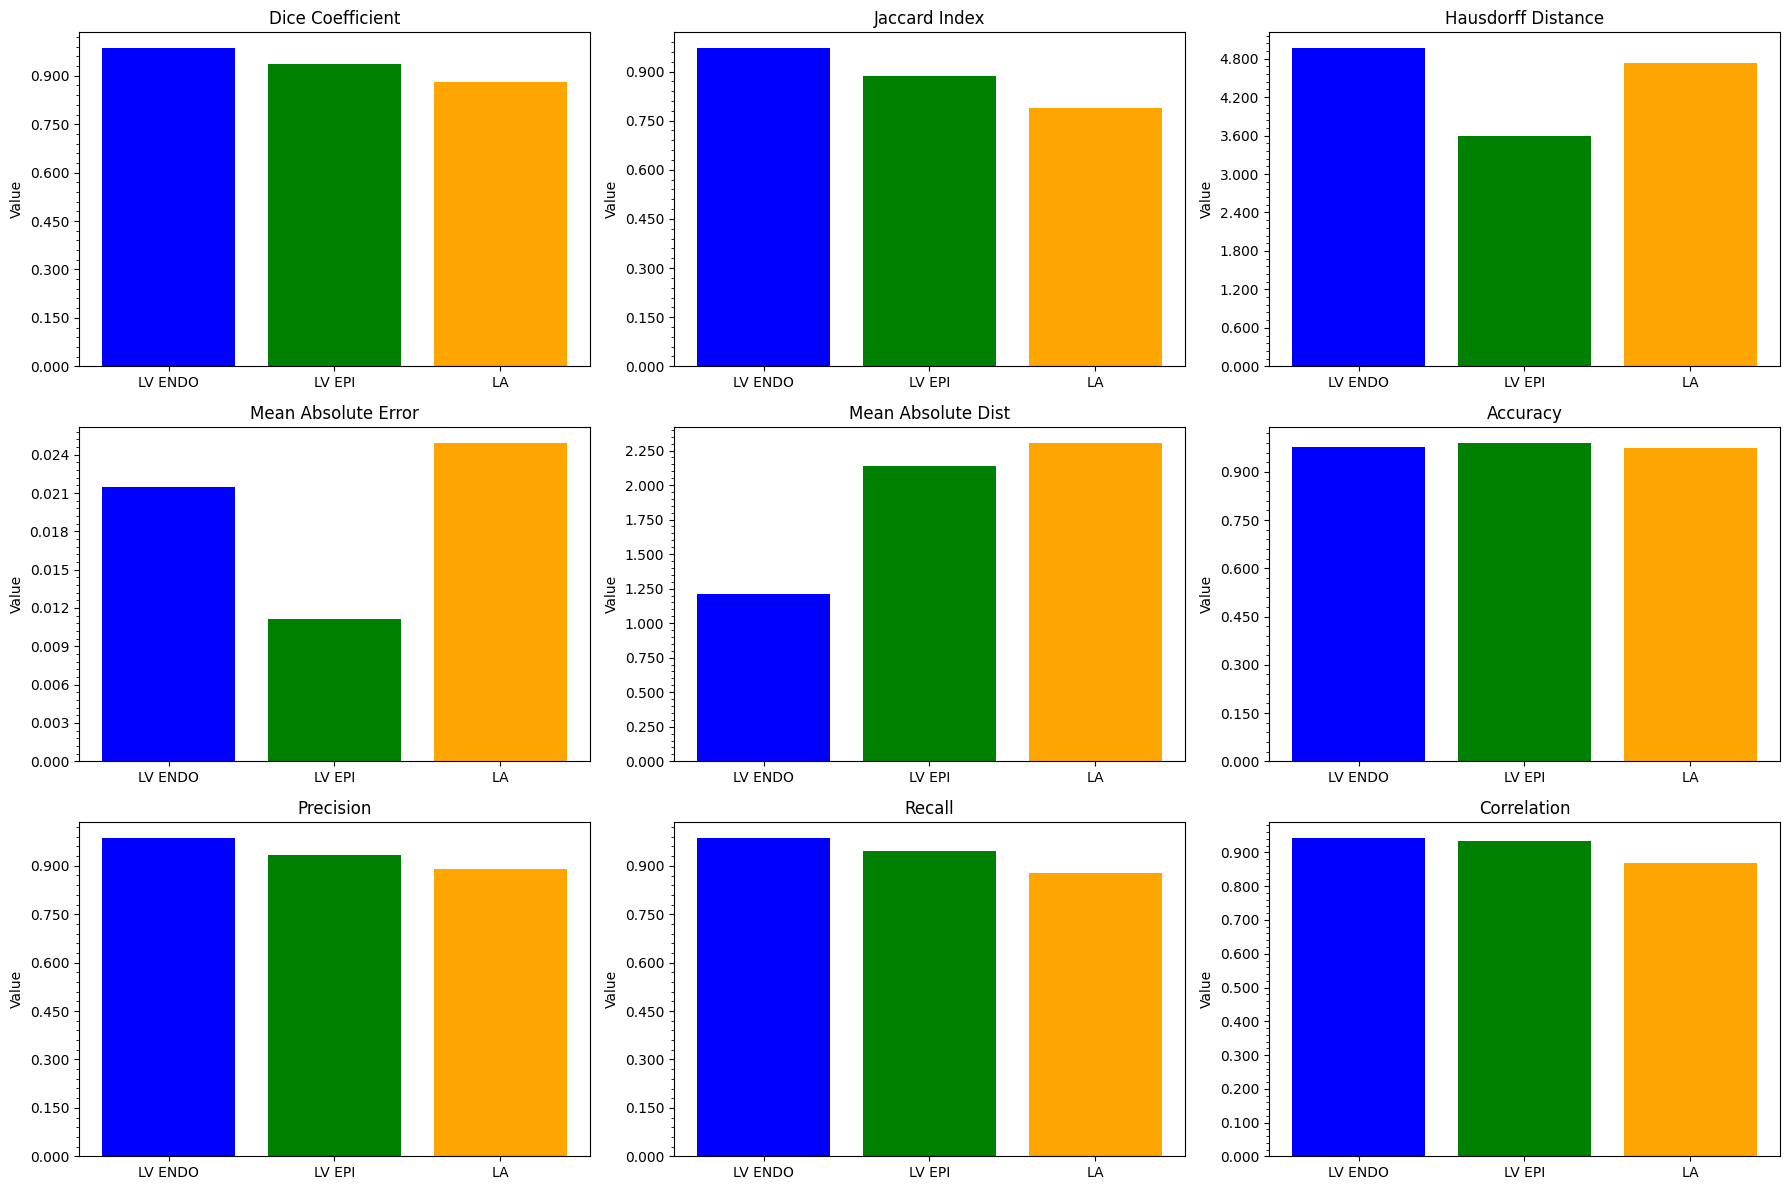

In [18]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel separately.
    Segments are assumed to be: LV ENDO, LV EPI, and LA.
    Then, create bar plots for each metric with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For LV ENDO, LV EPI, and LA

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Compute average metrics for each segment
    avg_dice = [np.nanmean(dice_scores[seg]) for seg in range(num_segments)]
    avg_jaccard = [np.nanmean(jaccard_scores[seg]) for seg in range(num_segments)]
    avg_hausdorff = [np.nanmean(hausdorff_scores[seg]) for seg in range(num_segments)]
    avg_mae = [np.mean(mae_scores[seg]) for seg in range(num_segments)]
    avg_mad = [np.mean(mad_scores[seg]) for seg in range(num_segments)]
    avg_accuracy = [np.mean(accuracies[seg]) for seg in range(num_segments)]
    avg_precision = [np.mean(precisions[seg]) for seg in range(num_segments)]
    avg_recall = [np.mean(recalls[seg]) for seg in range(num_segments)]
    avg_corr = [np.mean(correlations[seg]) for seg in range(num_segments)]

    # Define metric names and corresponding average values
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    metrics_values = [avg_dice, avg_jaccard, avg_hausdorff, avg_mae, avg_mad,
                      avg_accuracy, avg_precision, avg_recall, avg_corr]

    # Create a 3x3 grid of bar plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['LV ENDO', 'LV EPI', 'LA']
    for i, ax in enumerate(axs):
        ax.bar(segments, metrics_values[i], color=['blue', 'green', 'orange'])
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/2923852011.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 't

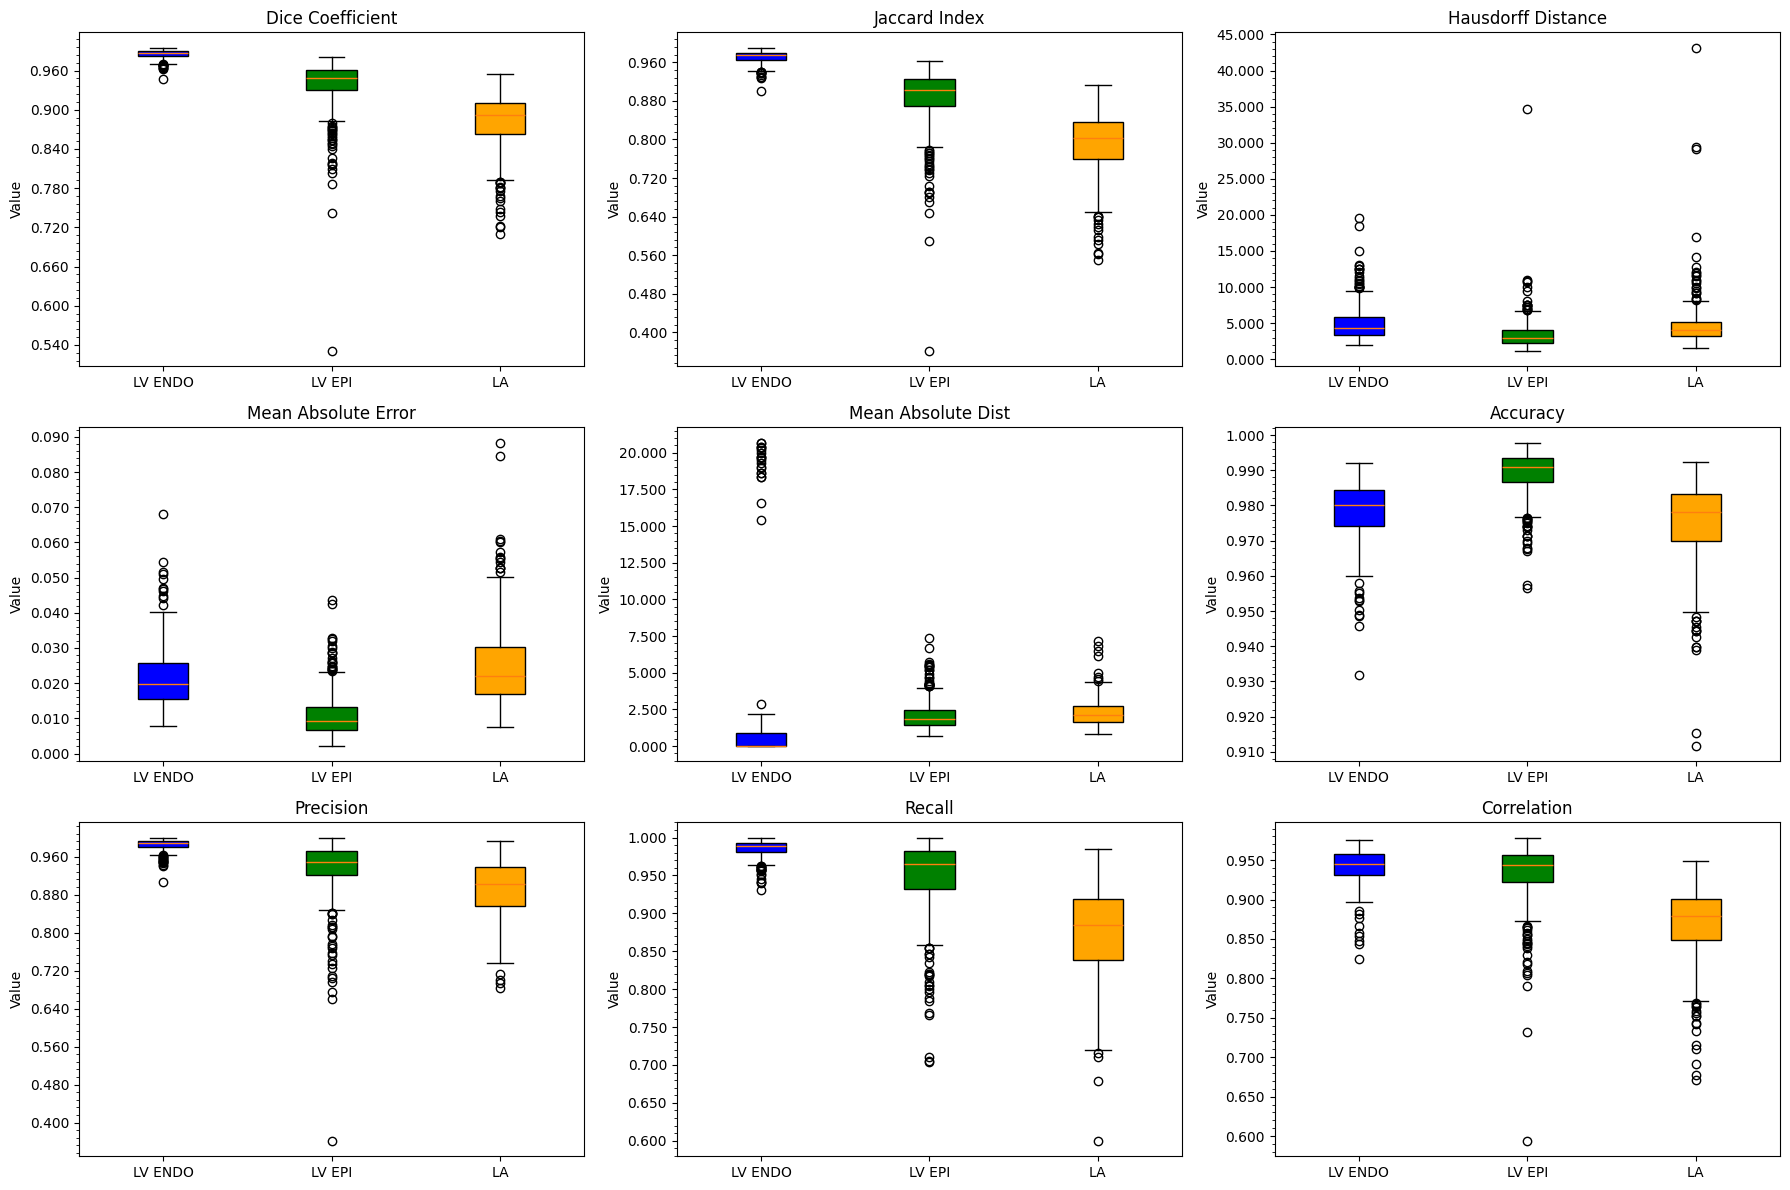

In [19]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel separately.
    Then, create box plots for each metric comparing LV ENDO, LV EPI, and LA with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For LV ENDO, LV EPI, and LA

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Define metric names and corresponding distributions (one per segment)
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    
    # Create a list of lists containing distributions for each metric:
    metrics_distributions = [
        dice_scores,
        jaccard_scores,
        hausdorff_scores,
        mae_scores,
        mad_scores,
        accuracies,
        precisions,
        recalls,
        correlations
    ]
    
    # Create a 3x3 grid of box plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['LV ENDO', 'LV EPI', 'LA']
    for i, ax in enumerate(axs):
        # Create a box plot for the metric distribution across segments
        bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Customize box colors if desired:
        colors = ['blue', 'green', 'orange']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
/tmp/ipykernel_2086506/1919006783.py:167: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 't

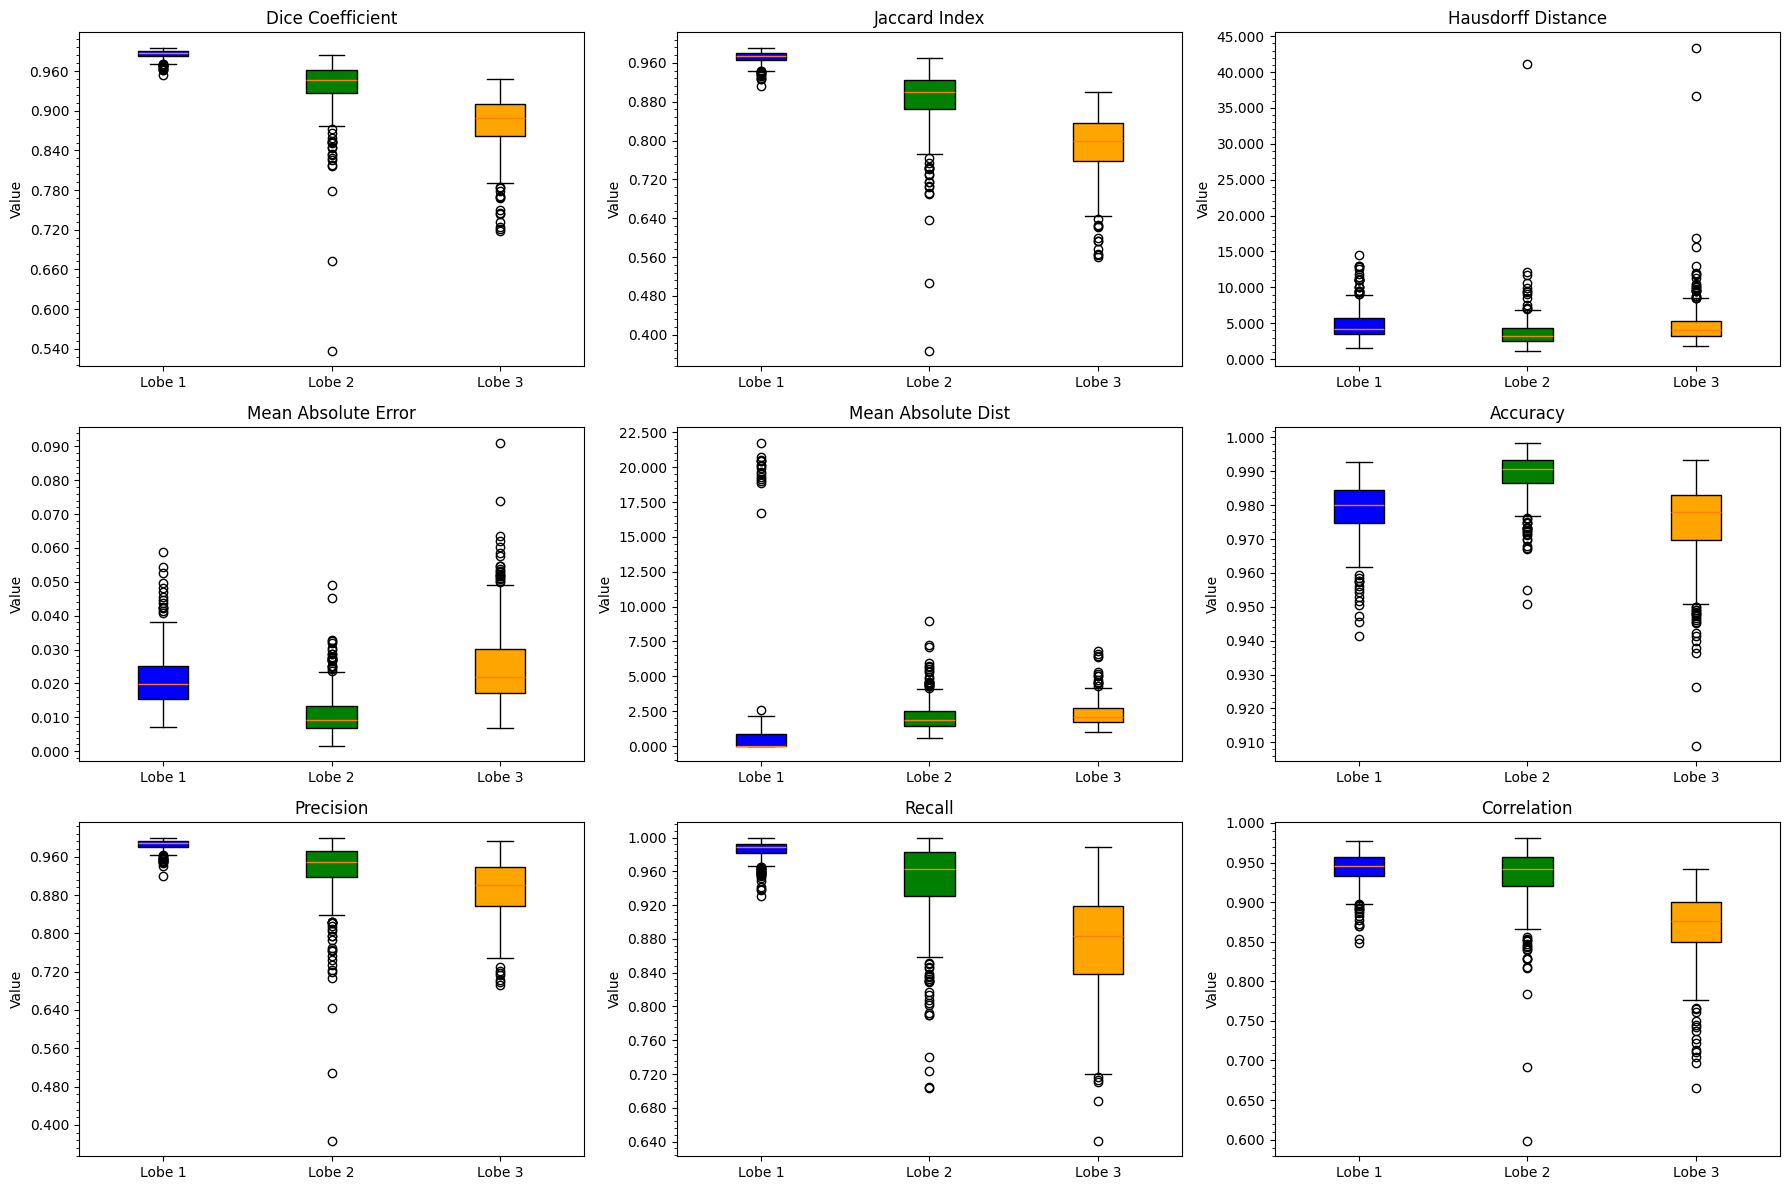

In [20]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel (lobe) separately.
    Then, create box plots for each metric comparing Lobe_1, Lobe_2, and Lobe_3 with increased y-axis scaling for precise readings.
    """
    num_segments = 3  # For Lobe_1, Lobe_2, and Lobe_3

    # Create a list for each metric per segment
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions with thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the segment channel (each is a 2D array)
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute metrics for this channel
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Define metric names and corresponding distributions (one per lobe)
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    
    # Create a list of lists containing distributions for each metric:
    metrics_distributions = [
        dice_scores,       # Each element is a list of values for Lobe 1, 2, and 3 respectively
        jaccard_scores,
        hausdorff_scores,
        mae_scores,
        mad_scores,
        accuracies,
        precisions,
        recalls,
        correlations
    ]
    
    # Create a 3x3 grid of box plots (one subplot per metric)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    segments = ['Lobe 1', 'Lobe 2', 'Lobe 3']
    for i, ax in enumerate(axs):
        # Create a box plot for the metric distribution across lobes
        bp = ax.boxplot(metrics_distributions[i], labels=segments, patch_artist=True)
        ax.set_title(metrics_names[i])
        ax.set_ylabel("Value")
        # Optionally, customize box colors:
        colors = ['blue', 'green', 'orange']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        # Increase the precision of the y-axis tick labels:
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)


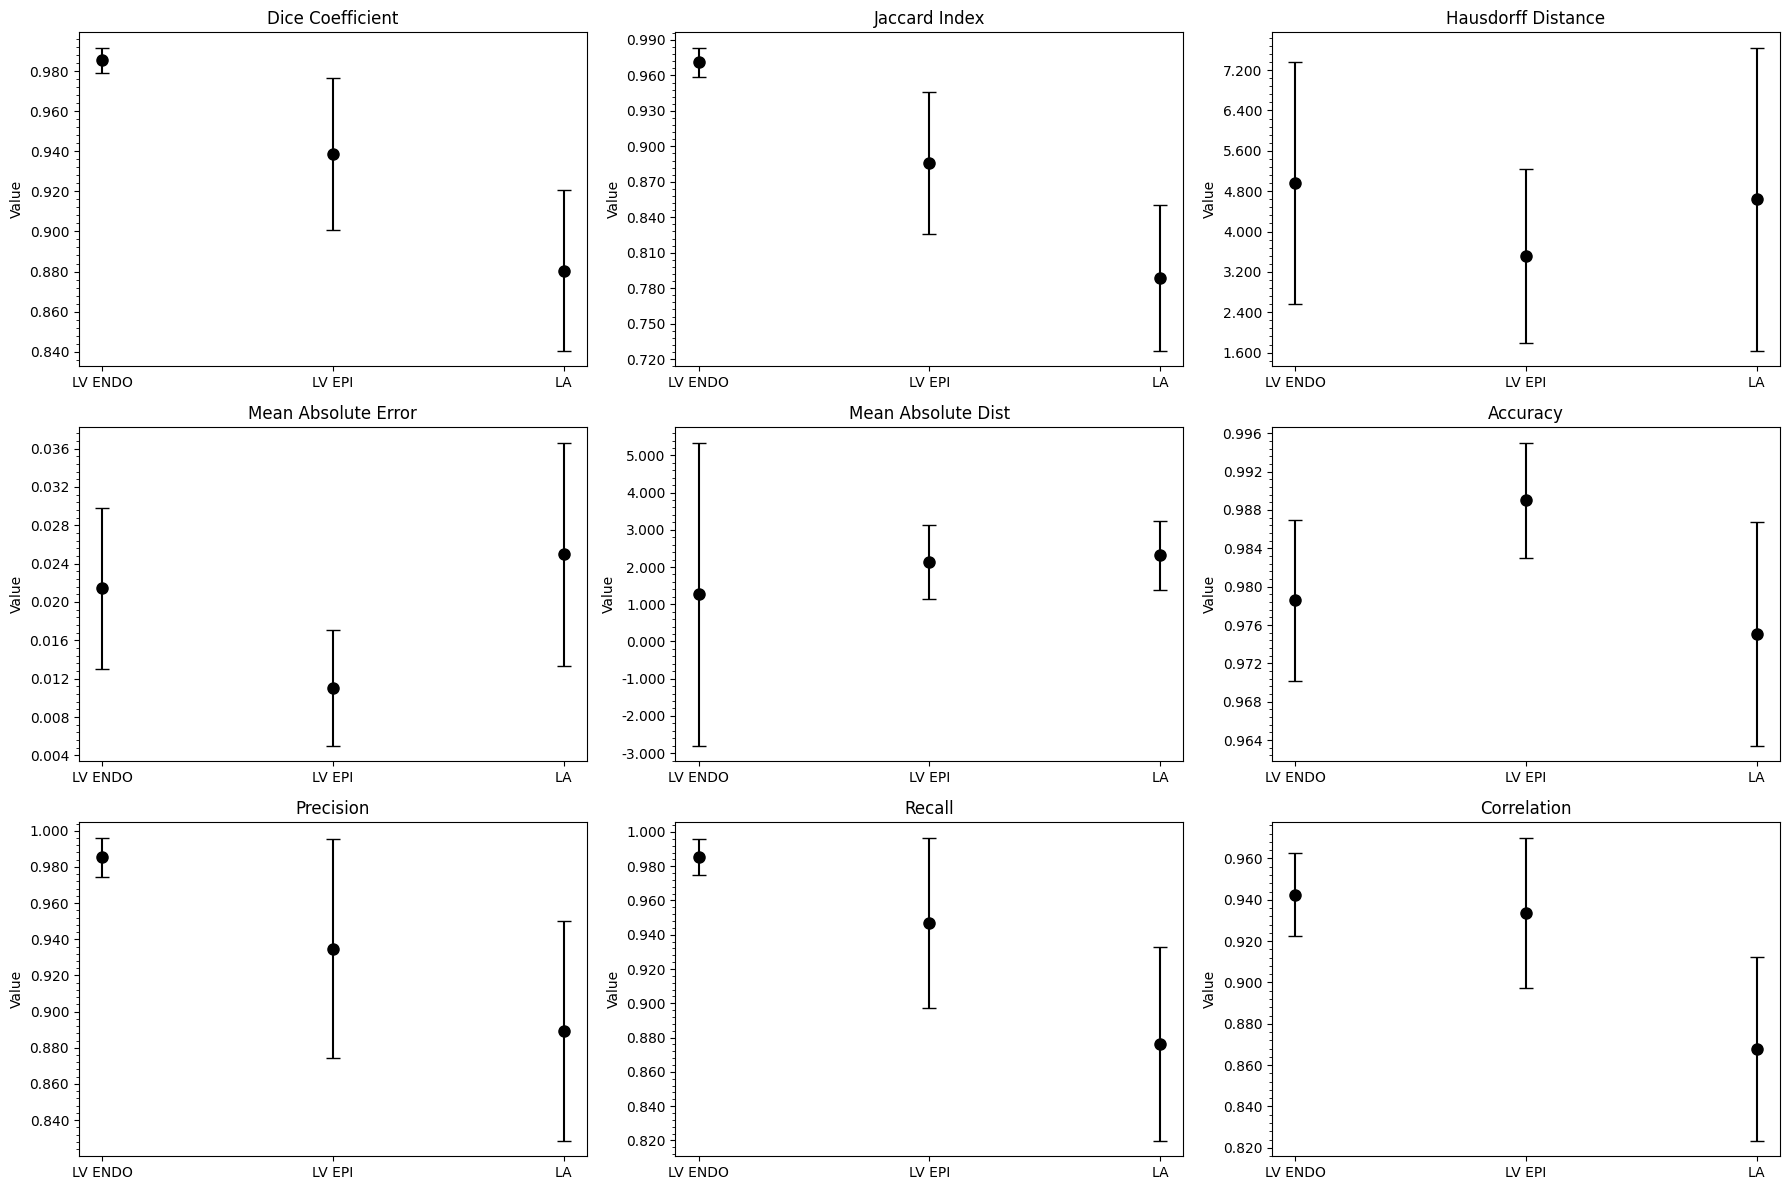

In [23]:
import numpy as np
import cv2
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error
import torch  # Ensure torch is imported
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FormatStrFormatter  # For precise y-axis scaling

# -------------------------------
# Single-Channel Metric Functions
# -------------------------------

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Compute Dice coefficient for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def jaccard_index(y_true, y_pred, smooth=1):
    """
    Compute Jaccard Index (IoU) for a single channel.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def hausdorff_distance_single(y_true, y_pred, conversion_factor=0.5):
    """
    Compute the symmetric Hausdorff distance for a single-channel mask and convert the result from pixels to mm.
    """
    coords_true = np.column_stack(np.where(y_true))
    coords_pred = np.column_stack(np.where(y_pred))
    if coords_true.shape[0] == 0 or coords_pred.shape[0] == 0:
        return np.nan  # or a large number if you prefer
    d_forward = directed_hausdorff(coords_true, coords_pred)[0]
    d_backward = directed_hausdorff(coords_pred, coords_true)[0]
    distance_in_pixels = max(d_forward, d_backward)
    return distance_in_pixels * conversion_factor

def mean_absolute_distance_single(y_true, y_pred):
    """
    Compute the Mean Absolute Distance (MAD) between the boundaries of a single-channel mask.
    """
    mask_true = (y_true * 255).astype(np.uint8)
    mask_pred = (y_pred * 255).astype(np.uint8)
    contours_true, _ = cv2.findContours(mask_true, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_pred, _ = cv2.findContours(mask_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours_true) == 0 or len(contours_pred) == 0:
        return np.nan
    points_true = np.vstack(contours_true)[:, 0, :]
    points_pred = np.vstack(contours_pred)[:, 0, :]

    dists = []
    for pt in points_true:
        dists.append(np.min(np.linalg.norm(points_pred - pt, axis=1)))
    return np.mean(dists)

def compute_classification_metrics(y_true, y_pred):
    """
    Compute pixel-wise Accuracy, Precision, and Recall for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    acc = accuracy_score(y_true_flat, y_pred_flat)
    prec = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    rec = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    return acc, prec, rec

def compute_correlation(y_true, y_pred):
    """
    Compute Pearson correlation coefficient for a single channel.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    return np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

# -------------------------------
# Evaluation Function for Each Segment with Error Bar Plot
# -------------------------------

def evaluate_model_by_segment(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model and compute metrics for each segmentation channel separately.
    Segments are assumed to be: LV ENDO, LV EPI, and LA.
    Then, create a multi-channel error bar plot for each metric (mean ± std) with precise y-axis scaling.
    """
    num_segments = 3  # For LV ENDO, LV EPI, and LA

    # Initialize lists to collect per-sample metric values for each channel.
    dice_scores      = [[] for _ in range(num_segments)]
    jaccard_scores   = [[] for _ in range(num_segments)]
    hausdorff_scores = [[] for _ in range(num_segments)]
    mae_scores       = [[] for _ in range(num_segments)]
    mad_scores       = [[] for _ in range(num_segments)]
    accuracies       = [[] for _ in range(num_segments)]
    precisions       = [[] for _ in range(num_segments)]
    recalls          = [[] for _ in range(num_segments)]
    correlations     = [[] for _ in range(num_segments)]

    model.eval()
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            # Convert logits to binary predictions using thresholding
            preds = (torch.sigmoid(outputs) > threshold).float()

            # Move predictions and masks to CPU and convert to numpy arrays
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            # Change shape from (batch, channels, H, W) to (batch, H, W, channels)
            preds = np.transpose(preds, (0, 2, 3, 1))
            masks = np.transpose(masks, (0, 2, 3, 1))

            for pred_mask, true_mask in zip(preds, masks):
                for seg in range(num_segments):
                    # Extract the channel corresponding to each segment.
                    channel_pred = pred_mask[..., seg]
                    channel_true = true_mask[..., seg]

                    # Compute and store metrics for this channel.
                    dice_scores[seg].append(dice_coefficient(channel_true, channel_pred))
                    jaccard_scores[seg].append(jaccard_index(channel_true, channel_pred))
                    hausdorff_scores[seg].append(hausdorff_distance_single(channel_true, channel_pred))
                    mae_scores[seg].append(mean_absolute_error(channel_true.flatten(), channel_pred.flatten()))
                    mad_scores[seg].append(mean_absolute_distance_single(channel_true, channel_pred))

                    acc, prec, rec = compute_classification_metrics(channel_true, channel_pred)
                    accuracies[seg].append(acc)
                    precisions[seg].append(prec)
                    recalls[seg].append(rec)

                    correlations[seg].append(compute_correlation(channel_true, channel_pred))

    # Define metric names and organize the distributions for each metric.
    metrics_names = ["Dice Coefficient", "Jaccard Index", "Hausdorff Distance",
                     "Mean Absolute Error", "Mean Absolute Dist", "Accuracy",
                     "Precision", "Recall", "Correlation"]
    metrics_distributions = [
        dice_scores,
        jaccard_scores,
        hausdorff_scores,
        mae_scores,
        mad_scores,
        accuracies,
        precisions,
        recalls,
        correlations
    ]
    channels = ['LV ENDO', 'LV EPI', 'LA']

    # Create a 3x3 grid of error bar plots (one subplot per metric).
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        # Compute mean and standard deviation for each channel of the current metric.
        means = [np.nanmean(metrics_distributions[i][ch]) for ch in range(num_segments)]
        stds = [np.nanstd(metrics_distributions[i][ch]) for ch in range(num_segments)]
        x = np.arange(len(channels))
        # Plot mean values with error bars representing the standard deviation.
        ax.errorbar(x, means, yerr=stds, fmt='o', capsize=5, color='black', markersize=8)
        ax.set_title(metrics_names[i])
        ax.set_xticks(x)
        ax.set_xticklabels(channels)
        ax.set_ylabel("Value")
        ax.yaxis.set_major_locator(MaxNLocator(10))         # Up to 10 major ticks.
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))       # 5 minor ticks between majors.
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Tick labels with 3 decimals.
    plt.tight_layout()
    plt.show()

# -------------------------------
# How to Call the Evaluation Function
# -------------------------------
# Example: After training (or loading your best model), evaluate on the validation DataLoader:
evaluate_model_by_segment(model, val_loader, device)
